In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from sklearn.cluster import KMeans
import tiktoken
import openai
from tqdm import tqdm
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [113]:
DATA = r"./excel_files/gsm_train_question_embeddings.csv"
df = pd.read_csv(DATA)

In [114]:
df["embedding"] = df.embedding.apply(eval).apply(np.array)
matrix = np.vstack(df.embedding.values)
print(matrix.shape)

(7473, 1536)


    Function to count the number of tokens in text:

In [115]:
GPT_MODEL = "gpt-3.5-turbo" #for tokenizer selection
def num_tokens(text: str, model: str = GPT_MODEL) -> int:
    """Return the number of tokens in a string."""
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

### Finding ideal number of cluster using some metrics:

    Sum of squares to find number of clusters:

In [8]:
sum_of_squares = []
for i in tqdm(range(2, 15)):
    n_clusters = i
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(matrix)
    sum_of_squares.append(kmeans.inertia_)

100%|██████████| 13/13 [00:42<00:00,  3.26s/it]


In [9]:
for num, val in enumerate(sum_of_squares):
    print(num+2, val)

2 1706.7697348180823
3 1673.591974756943
4 1654.8528849652066
5 1639.9353269182363
6 1628.0411269886508
7 1614.9646011554873
8 1604.869042518346
9 1592.6650402629061
10 1582.7389275714295
11 1574.9299862025139
12 1566.0178818587717
13 1558.2630494101536
14 1551.2616384341527


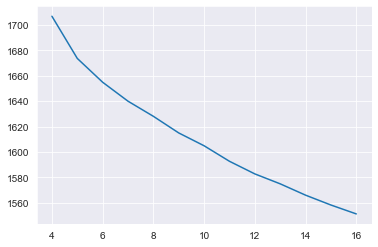

In [10]:
x = [i+2 for i in range(2,15)]
plt.plot(x,sum_of_squares)

    No clear winner, but 4/5 clusters seems to be the best options.

    Silhouette score to find number of clusters:

In [13]:
silhouette_avg = []
for i in tqdm(range(2, 15)):
    n_clusters = i
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(matrix)
    cluster_labels = kmeans.labels_
    # silhouette score
    silhouette_avg.append(silhouette_score(matrix, cluster_labels))

100%|██████████| 13/13 [01:10<00:00,  5.40s/it]


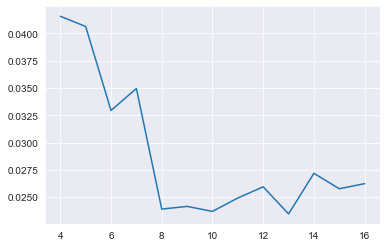

In [14]:
plt.plot(x,silhouette_avg)

### Clustering:

    We should also try to check ChatGPT cluster themes to check whether the clusters are meaningful.

    We know from previous analysis that we have several question types in our data, like time / money / distance / weight / proportion etc. So we should have more clusters to get more types of questions.

In [116]:
def cluster_tsne(matrix, df, n_clusters, n_components=2, perplexity=15, init="random"):
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
    kmeans.fit(matrix)
    labels = kmeans.labels_
    df["cluster"] = labels
    print("The count of questions per cluster is:")
    print(df.cluster.value_counts())
    #TSNE
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=42, init=init, learning_rate=200)
    vis_dims2 = tsne.fit_transform(matrix)

    x = [x for x, y in vis_dims2]
    y = [y for x, y in vis_dims2]

    colors4 = ["purple", "green", "red", "blue"]
    colors5 = ["purple", "green", "red", "blue", "orange"]
    colors6 = ["purple", "green", "red", "blue", "orange", "yellow"]
    colors7 = ["purple", "green", "red", "blue", "orange", "yellow", "pink"]

    if n_clusters == 4:
        colors = colors4
    elif n_clusters == 5:
        colors = colors5
    elif n_clusters == 6:
        colors = colors6
    elif n_clusters == 7:
        colors = colors7

    for category, color in enumerate(colors):
        xs = np.array(x)[df.cluster == category]
        ys = np.array(y)[df.cluster == category]
        plt.scatter(xs, ys, color=color, alpha=0.3)

        avg_x = xs.mean()
        avg_y = ys.mean()

        plt.scatter(avg_x, avg_y, marker="x", color=color, s=200)
    plt.title("Clusters identified visualized in language 2d using t-SNE")

### Trying to find the right number of clusters:

The count of questions per cluster is:
3    2431
1    2226
2    1491
0    1325
Name: cluster, dtype: int64


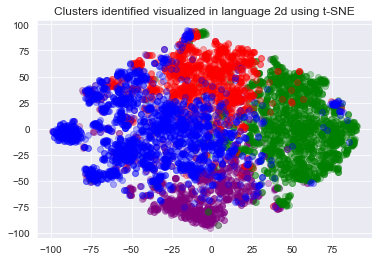

In [25]:
cluster_tsne(matrix, df, 4, n_components=2, perplexity=15)

The count of questions per cluster is:
4    2217
2    2113
0    1317
3    1269
1     557
Name: cluster, dtype: int64


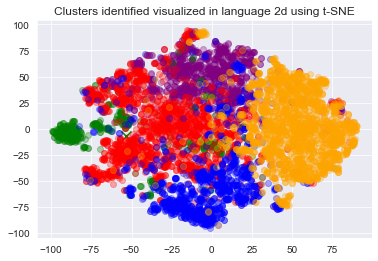

In [30]:
cluster_tsne(matrix, df, 5, n_components=2, perplexity=15)

The count of questions per cluster is:
5    2077
3    1310
0    1283
2    1251
4     953
1     599
Name: cluster, dtype: int64


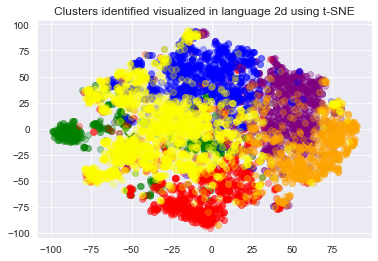

In [31]:
cluster_tsne(matrix, df, 6, n_components=2, perplexity=15)

The count of questions per cluster is:
3    1441
4    1288
0    1258
2    1167
6    1093
1     964
5     262
Name: cluster, dtype: int64


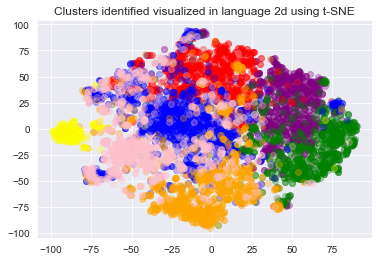

In [32]:
cluster_tsne(matrix, df, 7, n_components=2, perplexity=15)

    Chose 5 because one of the cluster choosing methods recommended it and also because my visual analysis seems to favor 5. I like the idea that we will have at least 5 exemplars in the prompt.

### Finding the right perplexity for t-SNE since larger datasets need larger perplexity values:

The count of questions per cluster is:
4    2217
2    2113
0    1317
3    1269
1     557
Name: cluster, dtype: int64


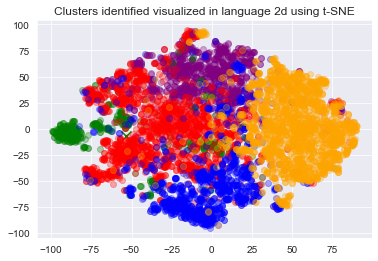

In [40]:
cluster_tsne(matrix, df, 5, n_components=2, perplexity=15)

The count of questions per cluster is:
4    2217
2    2113
0    1317
3    1269
1     557
Name: cluster, dtype: int64


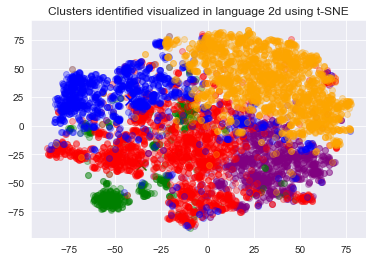

In [41]:
cluster_tsne(matrix, df, 5, n_components=2, perplexity=20)

The count of questions per cluster is:
4    2217
2    2113
0    1317
3    1269
1     557
Name: cluster, dtype: int64


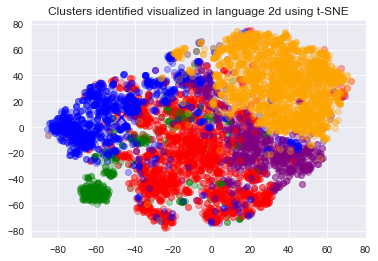

In [42]:
cluster_tsne(matrix, df, 5, n_components=2, perplexity=30)

The count of questions per cluster is:
4    2217
2    2113
0    1317
3    1269
1     557
Name: cluster, dtype: int64


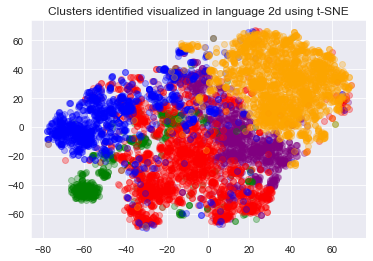

In [43]:
cluster_tsne(matrix, df, 5, n_components=2, perplexity=40)

The count of questions per cluster is:
4    2217
2    2113
0    1317
3    1269
1     557
Name: cluster, dtype: int64


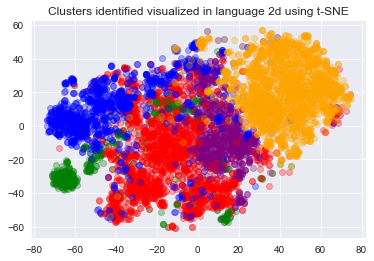

In [44]:
cluster_tsne(matrix, df, 5, n_components=2, perplexity=50)

The count of questions per cluster is:
4    2217
2    2113
0    1317
3    1269
1     557
Name: cluster, dtype: int64


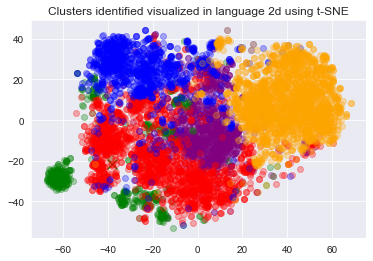

In [45]:
cluster_tsne(matrix, df, 5, n_components=2, perplexity=100)

The count of questions per cluster is:
4    2217
2    2113
0    1317
3    1269
1     557
Name: cluster, dtype: int64


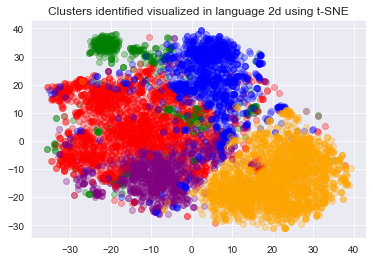

In [46]:
cluster_tsne(matrix, df, 5, n_components=2, perplexity=200)

    I'll go with a perplexity of 100. It appeals to me visually.

### Finding init method:

The count of questions per cluster is:
4    2217
2    2113
0    1317
3    1269
1     557
Name: cluster, dtype: int64


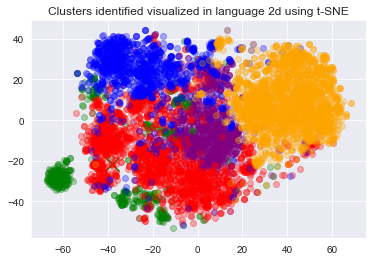

In [50]:
cluster_tsne(matrix, df, 5, n_components=2, perplexity=100, init="random")

The count of questions per cluster is:
4    2217
2    2113
0    1317
3    1269
1     557
Name: cluster, dtype: int64


c:\Users\kaush\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


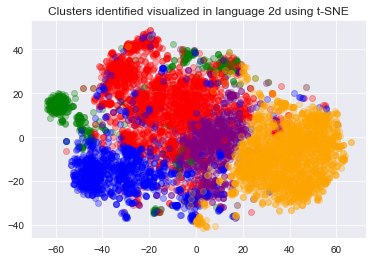

In [51]:
cluster_tsne(matrix, df, 5, n_components=2, perplexity=100, init="pca")

### Final clustering:

The count of questions per cluster is:
4    2217
2    2113
0    1317
3    1269
1     557
Name: cluster, dtype: int64


c:\Users\kaush\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


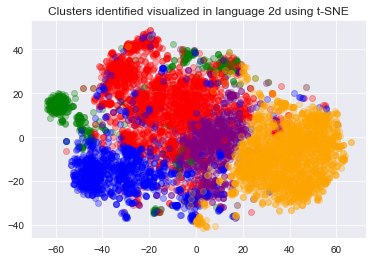

In [117]:
cluster_tsne(matrix, df, 5, n_components=2, perplexity=100,init="pca")

    Counting the number of tokens per cluster

In [118]:
question_cluster = []
grouped_questions = df.groupby("cluster").question.apply(list).values
for x in grouped_questions:
    question_cluster.append(x)
cluster_token_counts = []
for cluster in question_cluster:
    token_count = 0
    for question in cluster:
        token_count += num_tokens(question)
    cluster_token_counts.append(token_count)
print(cluster_token_counts)
# GPT3 has a limit of 4086 tokens per request, so we can't use the entire clusters as they are.
# We actually don't need to worry about this since we sample some questions from the cluster and not all of them.

[77329, 27049, 115633, 78011, 130287]


    Regular sampling version:

In [119]:
# Reading a questions which belong to each group.
questions_per_cluster = 20
# we sample 45 questions per cluster instead of 5
super_questions = []
n_clusters = 5
categories = ["money", "age", "food or weight", "time", "location", "proportion", "distance", "school", "sports"]
restricted_choices = ["Math Word Problems", "Various Math Word Problems", "Mathematics", "calculation"]

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    sampled_questions = "\n".join(
            df[df.cluster == i]
            .question
            .sample(questions_per_cluster, random_state=42)
            .values
        )

    ans = openai.ChatCompletion.create(
        model="gpt-3.5-turbo",
        max_tokens=500,
        stop="\n\n\n",
        messages=[
            {'role': 'system', 'content': 'You are a helpful assistant that will find the theme behind the following questions'},
            {'role': 'user', 'content': f"What do the following questions have in common?\nList of questions:\n{sampled_questions}\n\
                Answer with the theme. \
                Make sure the theme is not generic, perhaps choose amongst {categories} to guide your theme choice. \
                Do not answer with themes such as {restricted_choices}. \
                Do not repeat themes, even partially."}],
        temperature=0.0,
        top_p=1,
        n=1)
    theme = [choice['message']['content'] for choice in ans['choices']]
    print(" ".join(theme))
    super_questions.append([choice['message']['content'] for choice in ans['choices']][0])
 
    sample_cluster_rows = df[df.cluster == i].sample(questions_per_cluster, random_state=42)
    questions_to_display = 10
    for j in range(questions_to_display):
        # print(sample_cluster_rows.Score.values[j], end=", ")
        # print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.question.str[:70].values[j])
    print("-" * 100)

Cluster 0 Theme: The theme of these questions is "food or weight".
A candy store uses food colouring in various candies. Each lollipop us
Neeley bought a loaf of bread from the store and sliced it into 12 pie
Gordon owns 3 restaurants, his first restaurant serves 20 meals, his s
There are enough provisions in a castle to feed 300 people for 90 days
Mrs. Crocker made 11 pieces of fried chicken for Lyndee and her friend
Elizabeth has 10 reusable water bottles. She loses 2 water bottles at 
Alan has 8 pine trees in his backyard and each tree drops 200 pine con
Mark has 30 candies, Peter has 25 candies, and John has 35 candies. Th
Micah picks 2 dozen strawberries from the field.  He eats 6 and saves 
Bryan bought three different bottles of milk. The bottles contain the 
----------------------------------------------------------------------------------------------------
Cluster 1 Theme: The theme of these questions is "Age".
Tom fills a 250 pound sandbag 80% full.  But the filling material 

### Picking questions for the prompt:

    From each of these clusters, we shall pick the two longest questions to use. This is because we want to have a good representation of the questions in the cluster. 

    We will also change the questions to address some of GPT's weaknesses as reported by previous research works.

    Our themes are:
        - Food or weight
        - Age
        - Quantity and Proportion
        - Time
        - Money

    Sampling longest questions from each cluster:

In [120]:
df["question_length"] = df.question.apply(len)

In [122]:
df

,question,embedding,cluster,question_length
0,Natalia sold clips to 48 of her friends in Apr...,"[-0.014121408574283123, -0.01812637597322464, ...",2,155
1,Weng earns $12 an hour for babysitting. Yester...,"[0.010208266787230968, 0.010972762480378151, -...",4,113
2,Betty is saving money for a new wallet which c...,"[0.026983197778463364, -0.006650339812040329, ...",4,260
3,"Julie is reading a 120-page book. Yesterday, s...","[0.007657997775822878, 0.025833748281002045, 0...",3,219
4,James writes a 3-page letter to 2 different fr...,"[0.0032385073136538267, 0.006105619017034769, ...",3,103
...,...,...,...,...
7468,"Very early this morning, Elise left home in a ...","[0.027501145377755165, 0.013270754367113113, 0...",4,272
7469,Josh is saving up for a box of cookies. To rai...,"[0.00526996236294508, -0.010956649668514729, 0...",4,285
7470,Colin can skip at six times the speed that Bra...,"[0.008983314968645573, 0.009602399542927742, 0...",3,250
7471,"Janet, a third grade teacher, is picking up th...","[0.022984864190220833, 0.004620400257408619, -...",4,357


### Some operations:

In [124]:
gsm_train = pd.read_json(r"C:\Users\kaush\Desktop\fuck_you_chatPAL\pal\datasets\gsm_train.jsonl", lines=True)
answers = gsm_train.answer.values.tolist()

In [125]:
df["sample_generations"] = answers

In [126]:
sample_generations = df.sample_generations.values.tolist()
df.drop(columns=["sample_generations"], inplace=True)
solution = []
only_generations = []
for generation in sample_generations:
    x, y = generation.split("#### ")
    only_generations.append(x)
    solution.append(y)

In [127]:
df["generations"] = only_generations
df["solution"] = solution

In [128]:
df["generation_length"] = df.generations.apply(num_tokens)

In [129]:
df["total_length"] = df["generation_length"] + df["question_length"]

In [130]:
df

,question,embedding,cluster,question_length,generations,solution,generation_length,total_length
0,Natalia sold clips to 48 of her friends in Apr...,"[-0.014121408574283123, -0.01812637597322464, ...",2,155,Natalia sold 48/2 = <<48/2=24>>24 clips in May...,72,45,200
1,Weng earns $12 an hour for babysitting. Yester...,"[0.010208266787230968, 0.010972762480378151, -...",4,113,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...,10,51,164
2,Betty is saving money for a new wallet which c...,"[0.026983197778463364, -0.006650339812040329, ...",4,260,"In the beginning, Betty has only 100 / 2 = $<<...",5,77,337
3,"Julie is reading a 120-page book. Yesterday, s...","[0.007657997775822878, 0.025833748281002045, 0...",3,219,Maila read 12 x 2 = <<12*2=24>>24 pages today....,42,100,319
4,James writes a 3-page letter to 2 different fr...,"[0.0032385073136538267, 0.006105619017034769, ...",3,103,He writes each friend 3*2=<<3*2=6>>6 pages a w...,624,62,165
...,...,...,...,...,...,...,...,...
7468,"Very early this morning, Elise left home in a ...","[0.027501145377755165, 0.013270754367113113, 0...",4,272,"For the distance she traveled, Elise paid 23 -...",5,60,332
7469,Josh is saving up for a box of cookies. To rai...,"[0.00526996236294508, -0.010956649668514729, 0...",4,285,He makes $.5 profit on each bracelet because 1...,3,70,355
7470,Colin can skip at six times the speed that Bra...,"[0.008983314968645573, 0.009602399542927742, 0...",3,250,Tony can skip at twice the speed that Bruce ca...,4,93,343
7471,"Janet, a third grade teacher, is picking up th...","[0.022984864190220833, 0.004620400257408619, -...",4,357,Janet needs 35 lunches for the kids + 5 for th...,308,74,431


In [12]:
questions_per_cluster = 20
sampled_questions = {}
for cluster_num in range(0,5):
    sampled_questions[cluster_num] = []
    cluster_questions = df[df.cluster == cluster_num].question.values.tolist()
    # print(cluster_questions)
    #now let's pick the longest questions from this cluster:
    #we have the questions in a list, so we can use the max function
    for i in range(0, questions_per_cluster):
        current_question = max(cluster_questions, key=len)
        sampled_questions[cluster_num].append(current_question)
        cluster_questions.remove(current_question)

In [17]:
food_questions = sampled_questions[0][0:5]
age_questions = sampled_questions[1][0:20]
proportion_questions = sampled_questions[2][0:5]
time_questions = sampled_questions[3][0:20]
money_questions = sampled_questions[4][0:5]

    We manually check if the longest questions actually correspond to the categories they were assigned or whether they are outliers. We only add the questions that are actually relevant to the category since we want representative questions.

In [28]:
time_questions[3]

'Jo-Bob hopped into the hot air balloon, released the anchor rope, and pulled on the lift chain, which ignited the flame and provided the warm air that caused the balloon to rise.  When the lift chain was pulled, the balloon would rise at a rate of 50 feet per minute.  But when the chain was not being pulled, the balloon would slowly descend at a rate of 10 feet per minute.  During his balloon ride, he pulled the chain for 15 minutes, then released the rope for 10 minutes, then pulled the chain for another 15 minutes, and finally released the chain and allowed the balloon to slowly descend back to the earth.  During his balloon ride, what was the highest elevation reached by the balloon?'

In [124]:
final_questions_for_prompt = []
#regular version
final_questions_for_prompt.append(food_questions[0])
final_questions_for_prompt.append(food_questions[1])
final_questions_for_prompt.append(age_questions[0])
final_questions_for_prompt.append(age_questions[6]) #questionable question
final_questions_for_prompt.append(proportion_questions[0])
final_questions_for_prompt.append(proportion_questions[1])
final_questions_for_prompt.append(time_questions[0])
final_questions_for_prompt.append(time_questions[1])
final_questions_for_prompt.append(money_questions[0])
final_questions_for_prompt.append(money_questions[1])

In [123]:
j = 0
print(len(money_questions[j]))
print(money_questions[j])

859
A man is trying to maximize the amount of money he saves each month. In particular, he is trying to decide between two different apartments. The first apartment costs $800 per month in rent and will cost an additional $260 per month in utilities. The second apartment costs $900 per month and will cost an additional $200 per month in utilities. The first apartment is slightly further from the man's work, and the man would have to drive 31 miles per day to get to work. The second apartment is closer, and the man would only have to drive 21 miles to get to work. According to the IRS, each mile a person drives has an average cost of 58 cents. If the man must drive to work 20 days each month, what is the difference between the total monthly costs of these two apartments after factoring in utility and driving-related costs (to the nearest whole dollar)?


In [99]:
j = 0
print(len(age_questions[j]))
print(age_questions[j])

581
Five coworkers were talking during the lunch break. Roger, the oldest one, said that he has the same amount of experience in years as all four of the others combined and that his retirement should come when he accumulates 50 years of experience. Peter said that when he came to the company his daughter was 7 years old, and now she is 19 years old. Tom then said he has twice as many years of experience as Robert. Robert said that he has 4 years of experience less than Peter but 2 more years of experience than Mike. How many more years does Roger have to work before he retires?


In [114]:
j = 6 #very questionable question
print(len(age_questions[j]))
print(age_questions[j])

488
James decides to use tannerite to blow things up to reveal his baby's gender. The explosion ignites both his neighbors' houses and attracts a police officer, who arrests James on two count of arson, one count of manufacturing explosives, and one count of domestic terrorism. If the arson counts each carry a 6-year sentence, the explosives sentence is twice as long as the total arson sentence, and the domestic terrorism charge's sentence is 20 years, how long might James spend in jail?


In [127]:
len(final_questions_for_prompt)

10

In [130]:
new_prompt_df = pd.DataFrame(final_questions_for_prompt, columns=['question'])

In [132]:
new_prompt_df.to_csv('./excel_files/clustering_based_prompt_questions.csv', index=False)

    Checking whether we are close to the token limit:

In [128]:
tokens_in_prompt = 0
for question in final_questions_for_prompt:
    tokens_in_prompt += num_tokens(question)

In [129]:
tokens_in_prompt

1625

# Operations end

    Sampling questions longest answers from each cluster:

In [142]:
from scipy.stats import rankdata

In [143]:
a = [1, 2, 3, 4]
print(rankdata(a, method="ordinal"))
print(len(a) - rankdata(a, method="max") + 1)

[1 2 3 4]
[4 3 2 1]


In [144]:
x = df[df.cluster == 0].generation_length.values.tolist()
print(rankdata(x, method="ordinal"))
ranks = rankdata(x, method="ordinal")
#after ranking I want to pick the argmax
print(np.argmax(ranks))
print(np.argmax(x))
#append the question at this index to the question set.
#remove this question from the list of questions
#remove the generation at this index from the list of generations

[ 409  888  925 ... 1119 1106 1044]
47
47


In [145]:
count = 20
sampled_questions = {}
for cluster_num in range(0,5):
    sampled_questions[cluster_num] = []
    cluster_questions = df[df.cluster == cluster_num].question.values.tolist()
    generation_lengths = df[df.cluster == cluster_num].generation_length.values.tolist()
    for i in range(0, count):
        max_index = np.argmax(generation_lengths)
        sampled_questions[cluster_num].append(cluster_questions[max_index])
        generation_lengths.remove(generation_lengths[max_index])
        cluster_questions.remove(cluster_questions[max_index])

    Our themes are:
        - Food or weight
        - Age
        - Quantity and Proportion
        - Time
        - Money

In [146]:
sampled_questions[0]

["Cary is an engineer in charge of designing an irrigation system for three farmers. Farmer Bob grows 3 acres of corn, 9 acres of cotton, and 12 acres of beans. Farmer Brenda grows 6 acres of corn, 7 acres of cotton, and 14 acres of beans. Farmer Bernie grows 2 acres of corn and 12 acres of cotton. If corn takes 20 gallons of water an acre, cotton takes 80 gallons of water an acre, and beans take twice as much water as corn, what percentage of the total water used will go to Farmer Bob's farm?", 'Haley is making cider. It takes 20 golden delicious apples and 40 pink lady apples to make one pint of cider. Each of her 6 farmhands can pick 240 apples per hour and will work 5 hours today. How many pints of cider can Haley make with the apples gathered today, provided that the ratio of golden delicious apples to pink lady apples gathered is 1:2?', 'Janet takes two multivitamins and 3 calcium supplements every day for the first 2 weeks of the month. For the last two weeks of the month, she r

In [147]:
food_questions = sampled_questions[0][0:5]
age_questions = sampled_questions[1][0:5]
proportion_questions = sampled_questions[2][0:5]
time_questions = sampled_questions[3][0:5]
money_questions = sampled_questions[4][0:5]

In [148]:
pp(money_questions[1])

("Nancy's ex owes her child support. He's supposed to pay 30% of his income "
 'each year. For 3 years, he made $30,000/year, then he got a 20% raise for '
 "the next four years. If he's only ever paid $1,200, how much does he owe "
 'her?')


In [149]:
final_questions_for_prompt = []
final_questions_for_prompt.append(food_questions[0])
final_questions_for_prompt.append(food_questions[1])
final_questions_for_prompt.append(proportion_questions[0])
final_questions_for_prompt.append(proportion_questions[1])
final_questions_for_prompt.append(time_questions[0])
final_questions_for_prompt.append(time_questions[1])
final_questions_for_prompt.append(money_questions[0])
final_questions_for_prompt.append(money_questions[1])
final_questions_for_prompt.append(age_questions[0]) #actually area questions this time
final_questions_for_prompt.append(age_questions[1]) #actually area questions this time

In [150]:
prompt_df = pd.DataFrame(final_questions_for_prompt, columns=['question'])
prompt_df

,question
0,Cary is an engineer in charge of designing an ...
1,Haley is making cider. It takes 20 golden deli...
2,Bella has two times as many marbles as frisbee...
3,"In a graveyard, there are 20 skeletons. Half ..."
4,Angelo and Melanie want to plan how many hours...
5,Martha needs to paint all four walls in her 12...
6,Janet hires six employees. Four of them are wa...
7,Nancy's ex owes her child support. He's suppos...
8,Jill is going to resod her front yard. The plo...
9,Matt wants to repaint his house. He needs to p...


In [151]:
prompt_df = prompt_df.merge(df, on="question", how="left")
prompt_df = prompt_df[["question", "generations", "solution"]]
prompt_df

,question,generations,solution
0,Cary is an engineer in charge of designing an ...,First figure out how much water beans take by ...,36
1,Haley is making cider. It takes 20 golden deli...,First figure out how many apples total are nee...,120
2,Bella has two times as many marbles as frisbee...,"When Bella buys 2/5 times more marbles, she'll...",140
3,"In a graveyard, there are 20 skeletons. Half ...",We first need to figure out how many of each t...,375
4,Angelo and Melanie want to plan how many hours...,Angelo and Melanie think they should dedicate ...,4
5,Martha needs to paint all four walls in her 12...,There are two walls that are 12' X 10' and two...,42
6,Janet hires six employees. Four of them are wa...,First figure out how many hours each worker wo...,22000
7,Nancy's ex owes her child support. He's suppos...,First find how much money the ex made during t...,69000
8,Jill is going to resod her front yard. The plo...,The area of the whole front yard is 200 feet b...,9474
9,Matt wants to repaint his house. He needs to p...,First figure out how many square feet a wall i...,1640


In [152]:
prompt_df.to_csv('./excel_files/clustering_based_generation_length_prompt_questions.csv', index=False)

    Sampling longest questions + answer from each cluster:

In [162]:
count = 20
sampled_questions = {}
for cluster_num in range(0,5):
    sampled_questions[cluster_num] = []
    cluster_questions = df[df.cluster == cluster_num].question.values.tolist()
    total_lengths = df[df.cluster == cluster_num].total_length.values.tolist()
    for i in range(0, count):
        max_index = np.argmax(total_lengths)
        sampled_questions[cluster_num].append(cluster_questions[max_index])
        total_lengths.remove(total_lengths[max_index])
        cluster_questions.remove(cluster_questions[max_index])

    Our themes are:
        - Food or weight
        - Age
        - Quantity and Proportion
        - Time
        - Money

In [163]:
sampled_questions[0]

['Hasan is packing up his apartment because he’s moving across the country for a new job. He needs to ship several boxes to his new home. The movers have asked that Hasan avoid putting more than a certain weight in pounds in any cardboard box. The moving company has helpfully provided Hasan with a digital scale that will alert him if a package is too heavy. Hasan is in the kitchen, and he fills a cardboard box with 38 dinner plates. When he checks the box, the scale reports his box is too heavy. Hasan knows each of his plates weighs 10 ounces. He removes a single plate from the box and checks the movers’ scale again. The scale reports his box is still too heavy. Hasan repeats the process again and again. When he has removed enough plates, the movers’ scale shows the box is now an acceptable weight for shipping. Hasan deduces that each shipping box can hold 20 pounds before the scale says the box is too heavy.  How many plates did Hasan need to remove from the shipping box?', 'A curry h

In [164]:
food_questions = sampled_questions[0][0:5]
age_questions = sampled_questions[1][0:5]
proportion_questions = sampled_questions[2][0:5]
time_questions = sampled_questions[3][0:5]
money_questions = sampled_questions[4][0:5]

In [165]:
pp(money_questions[1])

('As a freelancer, Baylor is paid for every finished work of a client he does '
 'on a freelance marketplace. Currently, he has $4000 on his dashboard from '
 'previous work done. He is currently working for three clients, with the '
 'first client paying him half the amount of money he currently has on his '
 'dashboard once the job is done. The second client will pay him 2/5 times '
 'more money than the first client once Baylor finishes his work. The third '
 'client will pay him twice the amount of money the first and second clients '
 'pay him together once he finishes the job. How much money will Baylor have '
 'in his dashboard after all the clients pay him for his work?')


In [166]:
final_questions_for_prompt = []
final_questions_for_prompt.append(food_questions[0])
final_questions_for_prompt.append(food_questions[1])
final_questions_for_prompt.append(age_questions[0]) #actually area questions this time
final_questions_for_prompt.append(age_questions[1]) #actually area questions this time
final_questions_for_prompt.append(proportion_questions[0])
final_questions_for_prompt.append(proportion_questions[1])
final_questions_for_prompt.append(time_questions[0])
final_questions_for_prompt.append(time_questions[1])
final_questions_for_prompt.append(money_questions[0])
final_questions_for_prompt.append(money_questions[1])


In [167]:
prompt_df = pd.DataFrame(final_questions_for_prompt, columns=['question'])
prompt_df

,question
0,Hasan is packing up his apartment because he’s...
1,A curry house sells curries that have varying ...
2,Five coworkers were talking during the lunch b...
3,Jill is going to resod her front yard. The plo...
4,Ellie went to visit a circus with Sarah and th...
5,Alec is running for Class President. He thinks...
6,"Sam works at the Widget Factory, assembling Wi..."
7,Angelo and Melanie want to plan how many hours...
8,A man is trying to maximize the amount of mone...
9,"As a freelancer, Baylor is paid for every fini..."


    60% overlap with question only dataset as usually question length greater than answer length

In [168]:
prompt_df = prompt_df.merge(df, on="question", how="left")
prompt_df = prompt_df[["question", "generations", "solution"]]
prompt_df

,question,generations,solution
0,Hasan is packing up his apartment because he’s...,Let x be the number of plates removed from the...,6
1,A curry house sells curries that have varying ...,The curry house previously bought 3 peppers pe...,40
2,Five coworkers were talking during the lunch b...,Peter has 19 – 7 = <<19-7=12>>12 years of expe...,8
3,Jill is going to resod her front yard. The plo...,The area of the whole front yard is 200 feet b...,9474
4,Ellie went to visit a circus with Sarah and th...,"In the rooms with tall mirrors, Sarah saw her ...",88
5,Alec is running for Class President. He thinks...,"To calculate Alec's goal number of votes, we n...",5
6,"Sam works at the Widget Factory, assembling Wi...",Sam completes a widget every 10 minutes.\nWhen...,30
7,Angelo and Melanie want to plan how many hours...,Angelo and Melanie think they should dedicate ...,4
8,A man is trying to maximize the amount of mone...,The mileage cost for the first apartment will ...,76
9,"As a freelancer, Baylor is paid for every fini...",The first client will pay Baylor 1/2*$4000=$<<...,18400


In [169]:
prompt_df.to_csv('./excel_files/clustering_based_total_length_prompt_questions.csv', index=False)

    post analysis modified prompt questions

In [41]:
modified_prompt_questions = []
#post analysis version
modified_prompt_questions.append(food_questions[0])
modified_prompt_questions.append(food_questions[1])
modified_prompt_questions.append(age_questions[0])
modified_prompt_questions.append(age_questions[6]) #questionable question
modified_prompt_questions.append(time_questions[0])
modified_prompt_questions.append(time_questions[1])
modified_prompt_questions.append(time_questions[2])
modified_prompt_questions.append(time_questions[3])
modified_prompt_questions.append(money_questions[0])
modified_prompt_questions.append(money_questions[1])
# final_questions_for_prompt.append(proportion_questions[0])
# final_questions_for_prompt.append(proportion_questions[1])
modified_prompt_questions = pd.DataFrame(modified_prompt_questions, columns=['question'])
prompt_df = modified_prompt_questions
prompt_df = prompt_df.merge(df, on="question", how="left")
prompt_df = prompt_df[["question", "generations", "solution"]]
prompt_df.to_csv('./excel_files/clustering_based_post_analysis.csv', index=False)
prompt_df

,question,generations,solution
0,Hasan is packing up his apartment because he’s...,Let x be the number of plates removed from the...,6
1,A curry house sells curries that have varying ...,The curry house previously bought 3 peppers pe...,40
2,Five coworkers were talking during the lunch b...,Peter has 19 – 7 = <<19-7=12>>12 years of expe...,8
3,James decides to use tannerite to blow things ...,First find the total sentence length for the a...,56
4,Tina is working on her homework when she reali...,Tina has already cleaned one key so she has 14...,52
5,"Sam works at the Widget Factory, assembling Wi...",Sam completes a widget every 10 minutes.\nWhen...,30
6,"At the beginning of the day, Principal Kumar i...",Half of the distance up the flagpole is 60/2 =...,180
7,"Jo-Bob hopped into the hot air balloon, releas...",The first 15-minute chain pull caused the ball...,1400
8,A man is trying to maximize the amount of mone...,The mileage cost for the first apartment will ...,76
9,"On Saturday morning, Renata had $10 to spend. ...",After the charity ticket purchase on Saturday ...,94


    random select baseline:

In [72]:
#randomly select 10 questions from the dataframe:
#this will tell us whether the length based stuff is working
df_random_sample = df.sample(n=10, random_state=666)
df_random_sample.cluster.value_counts()

0    3
3    2
2    2
4    2
1    1
Name: cluster, dtype: int64

In [75]:
prompt_df = df_random_sample
# prompt_df = prompt_df.merge(df, on="question", how="left")
prompt_df = prompt_df[["question", "generations", "solution"]]
prompt_df.to_csv('./excel_files/clustering_based_random_select_baseline.csv', index=False)
prompt_df

,question,generations,solution
5303,"On a particular day, a car traveled from Ningi...",If the car traveled from Ningi to Zipra in 80%...,108
2528,A rectangle has a length of 3 inches and a wid...,The area of the rectangle is 3 x 6 = <<3*6=18>...,7
4089,Martine has 6 more than twice as many peaches ...,Benjy has b peaches.\nMartine has 6+2b=16 peac...,15
5468,Dulce's father has eight orange trees on his f...,The total number of oranges in all the trees b...,960
808,Carla is taking attendance for her sixth-grade...,First find the number of absent students: 2 st...,23
6335,Barry wants to make a huge salad using only cu...,Let c be the number of cucumbers and t the num...,70
462,Roberto and Valerie are jumping rope at recess...,"Roberto skips 70 times per minute because 4,20...","2,250"
746,Sam shared a sum of money between his three co...,"Going by the ratio, for every 1 part that Amy ...",100
815,Bingley has 5 bracelets. Kelly gives Bingley a...,Kelly gives Bingley 16 / 4 = <<16/4=4>>4 brace...,6
1281,Sam bought a heavy safe with a combination loc...,If there were four rows of twenty gold bars ar...,1600000


    random select from cluster:

In [131]:
#randomly select 10 questions from the dataframe:
#this will tell us whether the length based stuff is working
cluster0_df = df[df.cluster == 0]
cluster1_df = df[df.cluster == 1]
cluster2_df = df[df.cluster == 2]
cluster3_df = df[df.cluster == 3]
cluster4_df = df[df.cluster == 4]
dfs = [cluster0_df, cluster1_df, cluster2_df, cluster3_df, cluster4_df]
questions = []
generations = []
solutions = []
for dataframe in dfs:
    df_random_sample = dataframe.sample(n=2)
    questions.extend(df_random_sample.question.values.tolist())
    generations.extend(df_random_sample.generations.values.tolist())
    solutions.extend(df_random_sample.solution.values.tolist())

In [133]:
some_df = pd.DataFrame({"question": questions, "generations": generations, "solution": solutions})


,question,generations,solution
0,Uncle Jude baked 256 cookies. He gave 15 cooki...,He gave twice 15 cookies to Anna which is 2*15...,188
1,Jeremy buys 30 watermelons. He eats 3 watermel...,Jeremey goes through 3+2=<<3+2=5>>5 watermelon...,6
2,James is building a hall of mirrors. Three of ...,First find the area of one of the long walls: ...,960
3,Seth lost 17.5 pounds. Jerome lost three times...,Seth = <<17.5=17.5>>17.5 pounds\nJerome = 3 * ...,89
4,"Last year, Peter organized a Fun Run for his c...",There were 200 - 40 = <<200-40=160>>160 runner...,320
5,"While bird watching, Gabrielle saw 5 robins, 4...",Gabrielle saw 5 + 4 + 3 = <<5+4+3=12>>12 birds...,20
6,"Three cats sat on a fence, meowing at the moon...",The second cat meowed twice as frequently as t...,55
7,"In a car racing competition, Skye drove a 6-ki...",Since time is obtained by dividing distance an...,180
8,Winston has 14 quarters. He then spends half a...,Winston has 350 cents because 14 x 25 = <<14*2...,300
9,Half of Jerome's money was $43. He gave $8 to ...,Jerome has $43 x 2 = $<<43*2=86>>86.\nAfter gi...,54


    single cluster baseline:

In [79]:
#randomly select 10 questions from the dataframe:
#this will tell us whether the representation really matters
cluster4_df = df[df.cluster == 4]
cluster4_df

,question,embedding,cluster,question_length,generations,solution,generation_length,total_length
1,Weng earns $12 an hour for babysitting. Yester...,"[0.010208266787230968, 0.010972762480378151, -...",4,113,Weng earns 12/60 = $<<12/60=0.2>>0.2 per minut...,10,51,164
2,Betty is saving money for a new wallet which c...,"[0.026983197778463364, -0.006650339812040329, ...",4,260,"In the beginning, Betty has only 100 / 2 = $<<...",5,77,337
8,Alexis is applying for a new job and bought a ...,"[0.014283386059105396, 0.0006138423923403025, ...",4,400,Let S be the amount Alexis paid for the shoes....,41,98,498
9,Tina makes $18.00 an hour. If she works more ...,"[-0.0007988913566805422, -0.014417723752558231...",4,232,She works 8 hours a day for $18 per hour so sh...,990,293,525
11,Tobias is buying a new pair of shoes that cost...,"[0.014350620098412037, -0.004612699616700411, ...",4,343,He saved up $110 total because 95 + 15 = <<95+...,5,122,465
...,...,...,...,...,...,...,...,...
7460,A school is adding 5 rows of seats to the audi...,"[0.020613418892025948, 0.00285832560621202, -0...",4,244,Ten seats amount to $30 x 10 = $<<30*10=300>>3...,1080,158,402
7466,Janet pays $40/hour for 3 hours per week of cl...,"[0.007866390980780125, 0.012535475194454193, 0...",4,189,First find the total Janet spends on clarinet ...,1040,153,342
7468,"Very early this morning, Elise left home in a ...","[0.027501145377755165, 0.013270754367113113, 0...",4,272,"For the distance she traveled, Elise paid 23 -...",5,60,332
7469,Josh is saving up for a box of cookies. To rai...,"[0.00526996236294508, -0.010956649668514729, 0...",4,285,He makes $.5 profit on each bracelet because 1...,3,70,355


In [85]:
questions_per_cluster = 10
sampled_questions = []
# sampled_questions[cluster_num] = []
cluster_questions = cluster4_df.question.values.tolist()
# print(cluster_questions)
#now let's pick the longest questions from this cluster:
#we have the questions in a list, so we can use the max function
for i in range(0, questions_per_cluster):
    current_question = max(cluster_questions, key=len)
    sampled_questions.append(current_question)
    cluster_questions.remove(current_question)

In [86]:
sampled_questions

["A man is trying to maximize the amount of money he saves each month. In particular, he is trying to decide between two different apartments. The first apartment costs $800 per month in rent and will cost an additional $260 per month in utilities. The second apartment costs $900 per month and will cost an additional $200 per month in utilities. The first apartment is slightly further from the man's work, and the man would have to drive 31 miles per day to get to work. The second apartment is closer, and the man would only have to drive 21 miles to get to work. According to the IRS, each mile a person drives has an average cost of 58 cents. If the man must drive to work 20 days each month, what is the difference between the total monthly costs of these two apartments after factoring in utility and driving-related costs (to the nearest whole dollar)?",
 'On Saturday morning, Renata had $10 to spend. She first went and made a $4 donation in exchange for a ticket to the local charity draw

In [88]:
prompt_df = pd.DataFrame(sampled_questions, columns=['question'])
prompt_df = prompt_df.merge(df, on="question", how="left")
prompt_df = prompt_df[["question", "generations", "solution"]]
prompt_df.to_csv('./excel_files/clustering_based_single_cluster_baseline.csv', index=False)
prompt_df

,question,generations,solution
0,A man is trying to maximize the amount of mone...,The mileage cost for the first apartment will ...,76
1,"On Saturday morning, Renata had $10 to spend. ...",After the charity ticket purchase on Saturday ...,94
2,"As a freelancer, Baylor is paid for every fini...",The first client will pay Baylor 1/2*$4000=$<<...,18400
3,Monica and Sheila are twins. Their mother gave...,The groceries cost $12 x 2 = $<<12*2=24>>24\nI...,35
4,An elementary school teacher is making Hallowe...,"Because it is cheaper to buy the packs of 5, t...",17
5,A rancher owns a mixture of 8 sheep and 5 catt...,"First, the 144 acres of grass will be eaten ac...",360
6,A professional company is hiring for a new pos...,The first candidate’s training will cost 1200 ...,850
7,When the strawberries at Fruity Farm are ready...,"To gain entry into the strawberry fields, Sall...",7
8,A plumber is trying to decide which of three d...,"If the plumber chooses the first job, he would...",250
9,"At the burger hut, you can buy a burger for $5...","To buy regular food items individually, they c...",10
